In [1]:
from pathlib import Path
import time
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt

exec(open("../functions.py").read())

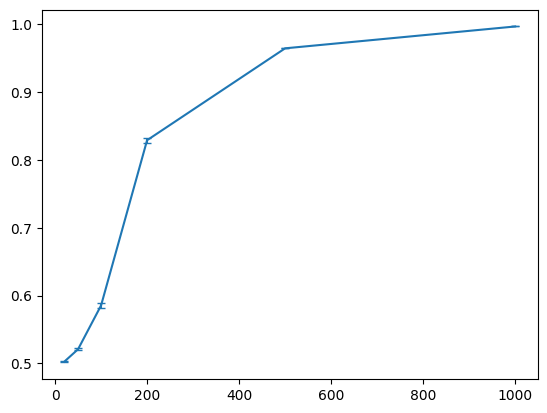

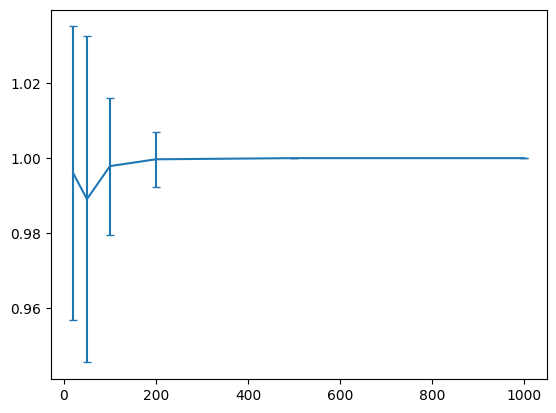

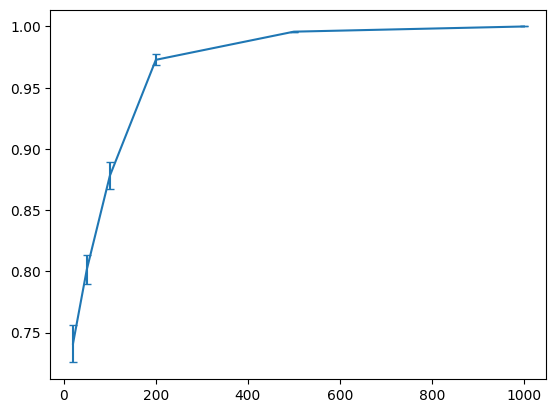

In [9]:
foot = jnp.arange(1000)/100
foo = jnp.asarray([jnp.sin(foot), jnp.cos(foot)]) * jnp.cos(foot * 100/3)
interval_n_s = jnp.asarray([1,2,5,10,20,50])[::-1]

init = np.zeros((3,2,6))
ref_cov = cov_s_fct(foo, jnp.mean(foo, axis = -1))
ref_pcs = es_s_fct(ref_cov)
ref_sizes = size_s_fct(ref_pcs[0])
for idx in range(6):
  temp_traj = jnp.swapaxes(foo.reshape(2,interval_n_s[idx], 1000//interval_n_s[idx]), 0,1)
  temp_cov = cov_s_fct(temp_traj, jnp.mean(temp_traj, axis = -1))
  temp_pcs = es_s_fct(temp_cov)
  init[0,0,idx] = jnp.mean(dim_r_s_fct(temp_pcs[0]))
  init[0,1,idx] = jnp.std(dim_r_s_fct(temp_pcs[0]))
  init[1,0,idx] = jnp.mean(size_s_fct(temp_pcs[0])/ref_sizes)
  init[1,1,idx] = jnp.std(size_s_fct(temp_pcs[0])/ref_sizes)
  init[2,0,idx] = jnp.mean(ori_similarity_s_fct(temp_pcs, ref_pcs, size_s_fct(temp_pcs[0]), ref_sizes))
  init[2,1,idx] = jnp.std(ori_similarity_s_fct(temp_pcs, ref_pcs, size_s_fct(temp_pcs[0]), ref_sizes))
for idx in range(3):
  plt.figure()
  plt.errorbar(1000 // interval_n_s, init[idx][0], yerr = init[idx][1], capsize = 3)

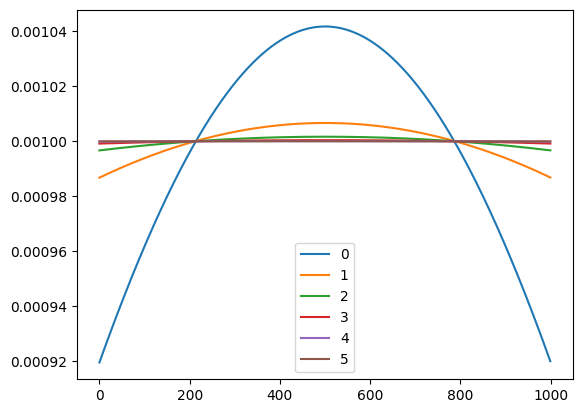

In [74]:
for idx in range(6):
  plt.plot(kernels[idx], label = idx)
  plt.legend()

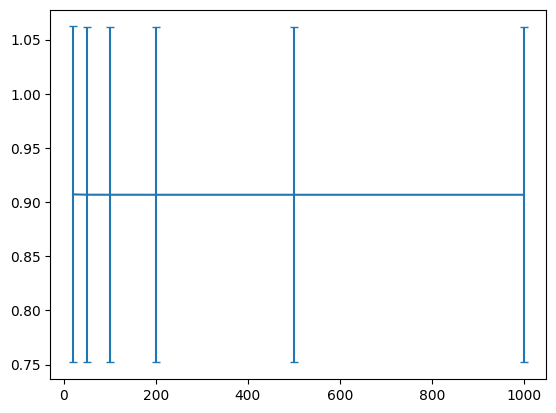

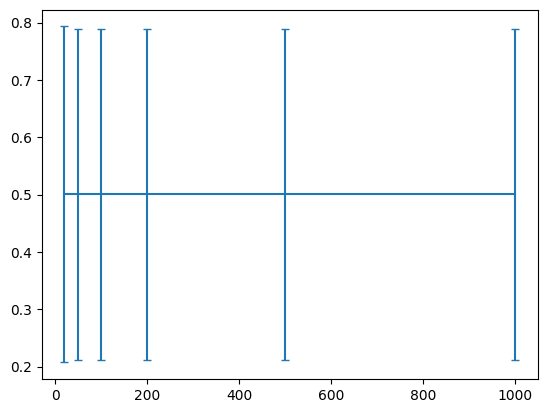

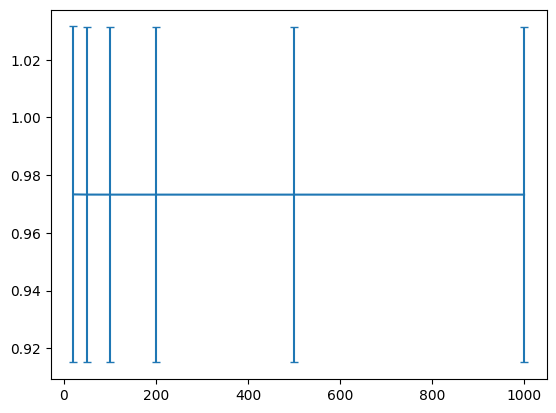

In [73]:
import scipy as sp

foot = jnp.arange(1000)/100
foo = jnp.asarray([jnp.sin(foot), jnp.cos(foot)]) * jnp.cos(foot * 100/3)
interval_n_s = jnp.asarray([1,2,5,10,20,50])[::-1]
kernels = jnp.exp(-(jnp.arange(-500,500)/100)**2 / 2/jnp.expand_dims(1000//interval_n_s / 2,1)**2)
kernels = kernels / jnp.sum(kernels, axis = -1,keepdims = True)

init = np.zeros((3,2,6))
ref_cov = cov_s_fct(foo, jnp.mean(foo, axis = -1))
ref_pcs = es_s_fct(ref_cov)
ref_sizes = size_s_fct(ref_pcs[0])
for idx in range(6):
  temp_cov = jnp.swapaxes(sp.signal.fftconvolve(jnp.expand_dims(foo,0) * jnp.expand_dims(foo,1), 
                                                jnp.tile(kernels[idx], (2,2,1)),
                                               axes = -1),
                         0,2)
  temp_pcs = es_s_fct(temp_cov)
  init[0,0,idx] = jnp.mean(dim_r_s_fct(temp_pcs[0]))
  init[0,1,idx] = jnp.std(dim_r_s_fct(temp_pcs[0]))
  init[1,0,idx] = jnp.mean(size_s_fct(temp_pcs[0])/ref_sizes)
  init[1,1,idx] = jnp.std(size_s_fct(temp_pcs[0])/ref_sizes)
  init[2,0,idx] = jnp.mean(ori_similarity_s_fct(temp_pcs, ref_pcs, size_s_fct(temp_pcs[0]), ref_sizes))
  init[2,1,idx] = jnp.std(ori_similarity_s_fct(temp_pcs, ref_pcs, size_s_fct(temp_pcs[0]), ref_sizes))
for idx in range(3):
  plt.figure()
  plt.errorbar(1000 // interval_n_s, init[idx][0], yerr = init[idx][1], capsize = 3)

In [2]:
# set basic parameters and subdirectory
part_n = 500
e_part_r = 0.8
e_mean = 4
ei_std_s = [4, 4]
waiting_time = 300
interval_len = 1200
subdirectory = ("{:n}_".format(part_n)
                + "{:n}_".format(e_part_r)
                + "{:n}_".format(e_mean)
                + "{0:n}-{1:n}_".format(ei_std_s[0],
                                        ei_std_s[1])
                + "{0:n}-{1:n}/".format(interval_len, 
                                        waiting_time))
#Path(subdirectory).mkdir()
print(ei_spectral_radius_fct(e_part_r, ei_std_s))

seed = 1695418797#round(time.time())
subdirectory = subdirectory + "{:n}".format(seed) + "/"
#Path(subdirectory).mkdir()
print(subdirectory)

4.0
500_0.8_4_4-4_1200-300/1695418797/


In [5]:
# generate and save parameters for simulation
key = jax.random.PRNGKey(seed)

sub_part_r_s = jnp.asarray([e_part_r, 1 - e_part_r])
sub_part_n_s = sub_part_n_s_fct(part_n, sub_part_r_s)
unscaled_mean = ei_mean_balancer(sub_part_r_s, e_mean)
unscaled_std = jnp.tile(jnp.asarray([ei_std_s]), (2, 1))
connectivity_n = 5
in_r = 1.
rewiring_prob = 1.
[connectivity_s, key] = row_sum_removing_sparsifier(connectivity_s_generator(sub_part_n_s,
                                                                             unscaled_mean, unscaled_std,
                                                                             connectivity_n,
                                                                             key),
                                                    sub_part_n_s, in_r, rewiring_prob)
jnp.savez(subdirectory + "parameter_s_1.npz",
          sub_part_r_s, sub_part_n_s, unscaled_mean, unscaled_std,
          connectivity_n,
          in_r, rewiring_prob,
          connectivity_s)

sub_part_n_s_ext_gen = jnp.asarray([part_n])
ext_part_n = part_n // 100
ext_sub_part_r_s = jnp.asarray([1.])
ext_sub_part_n_s = sub_part_n_s_fct(ext_part_n, ext_sub_part_r_s)
unscaled_ext_mean = jnp.asarray([[0.]])
unscaled_ext_std = jnp.asarray([[1.]])
ext_connectivity_n = 3
[ext_connectivity_s, key] = ext_connectivity_s_generator(sub_part_n_s_ext_gen, ext_sub_part_n_s,
                                                         unscaled_ext_mean, unscaled_ext_std,
                                                         ext_connectivity_n,
                                                         key)
jnp.savez(subdirectory + "parameter_s_2.npz",
          sub_part_n_s_ext_gen, 
          ext_part_n, ext_sub_part_r_s,
          ext_sub_part_n_s,
          unscaled_ext_mean, unscaled_ext_std, 
          ext_connectivity_n,
          ext_connectivity_s)

phase_n = 3
[phase_s, key] = phase_s_generator(ext_part_n, phase_n, key)
jnp.savez(subdirectory + "parameter_s_3.npz",
          phase_n,
          phase_s)

amp_s = jnp.expand_dims(jnp.asarray([0.2, 0.5, 1., 8.]), 
                        # or (wave_n, ext_part_n) array so different ext parts have different amps
                        1)
freq_s = jnp.full(amp_s.shape, 0.)
wave_s = jnp.concatenate([amp_s, freq_s], axis = 1)
wave_n = wave_s.shape[0]
jnp.savez(subdirectory + "parameter_s_4.npz",
          amp_s, freq_s,
          wave_s,
          wave_n)

initial_condition_n = 5
ext_condition_n = ext_connectivity_n * phase_n
initial_condition_n_free = initial_condition_n * ext_condition_n
[initial_condition_s, key] = initial_condition_s_generator(part_n, 
                                                           jnp.full((part_n, ), 0), jnp.identity(part_n), 
                                                           initial_condition_n_free, key)
jnp.savez(subdirectory + "parameter_s_5.npz",
          initial_condition_n,
          ext_condition_n, initial_condition_n_free,
          initial_condition_s)

label_s = jnp.asarray([1])
label_s_free = jnp.asarray([0])
time_interval_s = jnp.asarray([[0, interval_len]])
short_interval_n_s = jnp.asarray([20,10,6,3,2,1])
interval_len_s = (interval_len - waiting_time) // short_interval_n_s
jnp.savez(subdirectory + "parameter_s_6.npz",
          label_s, label_s_free,
          time_interval_s,
          short_interval_n_s,
          interval_len_s)
labeled_time_interval_s = [time_interval_s, label_s]
labeled_time_interval_s_free = [time_interval_s, label_s_free]

resolution = 24
jnp.savez(subdirectory + "parameter_s_7.npz",
          resolution)

condition_n_s = jnp.asarray([connectivity_n, wave_n, ext_connectivity_n, phase_n,
                             initial_condition_n])
condition_n_s_free = jnp.asarray([connectivity_n, 1, 1, 1,
                                  initial_condition_n_free])

In [3]:
# load parameters
[sub_part_r_s, sub_part_n_s, unscaled_mean, unscaled_std,
 connectivity_n,
 in_r, rewiring_prob,
 connectivity_s] = load_as_list(subdirectory + "parameter_s_1.npz")

[sub_part_n_s_ext_gen, 
 ext_part_n, ext_sub_part_r_s,
 ext_sub_part_n_s,
 unscaled_ext_mean, unscaled_ext_std, 
 ext_connectivity_n,
 ext_connectivity_s] = load_as_list(subdirectory + "parameter_s_2.npz")

[phase_n,
 phase_s] = load_as_list(subdirectory + "parameter_s_3.npz")

[amp_s, freq_s,
 wave_s,
 wave_n] = load_as_list(subdirectory + "parameter_s_4.npz")

[initial_condition_n,
 ext_condition_n, initial_condition_n_free,
 initial_condition_s] = load_as_list(subdirectory + "parameter_s_5.npz")

[label_s, label_s_free,
 time_interval_s,
 short_interval_n_s,
 interval_len_s] = load_as_list(subdirectory + "parameter_s_6.npz")
labeled_time_interval_s = [time_interval_s, label_s]
labeled_time_interval_s_free = [time_interval_s, label_s_free]

[resolution] = load_as_list(subdirectory + "parameter_s_7.npz")

condition_n_s = jnp.asarray([connectivity_n, wave_n, ext_connectivity_n, phase_n,
                             initial_condition_n])
condition_n_s_free = jnp.asarray([connectivity_n, 1, 1, 1,
                                  initial_condition_n_free])

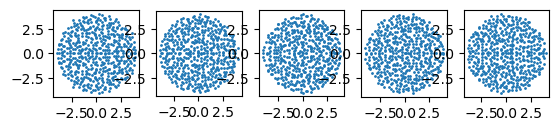

In [6]:
# plot spectra
[fig, subfig_s] = plt.subplots(1, int(connectivity_n))
for connectivity_idx in range(connectivity_n):
  temp_spectrum = jnp.linalg.eig(connectivity_s[connectivity_idx])[0]
  subfig_s[connectivity_idx].plot(jnp.real(temp_spectrum), jnp.imag(temp_spectrum),
                                  linestyle="", marker=".", markersize = 2)
  subfig_s[connectivity_idx].set_aspect('equal')

In [10]:
import jax # for jax.jit
import jax.numpy as jnp
import jax.random as jrandom
import time
# # allow double floats
# import jax.config as jconfig
# jconfig.update("jax_enable_x64", True)
# # to check
# jrandom.uniform(jrandom.PRNGKey(0), (1000, ), dtype=jnp.float64).dtype



# python: variable_name, ClassName, GLOBAL_VARIABLE_NAME
# MMA: variableName, selfFunction, $globalVariableName



# for obtaining conditions
# sub population sizes
def sub_part_n_s_fct(part_n_s, sub_part_r_s):
  # calculate rough numbers
  if jnp.asarray(part_n_s).size > 1:
    reshaped_part_n_s = jnp.swapaxes(jnp.atleast_2d(part_n_s), 0, 1)
    sub_part_n_s = jnp.floor(reshaped_part_n_s * sub_part_r_s)
  else:
    sub_part_n_s = jnp.floor(part_n_s * sub_part_r_s)
  # in case the rounded numbers don't add up
  sub_part_n_s = sub_part_n_s.at[..., -1].set(part_n_s - jnp.sum(sub_part_n_s[..., :-1],
                                                               axis = -1))
  return(sub_part_n_s.astype(int))

# (scaled or unscaled) mean calculator
def ei_mean_balancer(ei_part_n_s, e_mean):
  return(jnp.tile(jnp.asarray([e_mean, - e_mean * ei_part_n_s[0] / ei_part_n_s[1]]), (2, 1)))

# intensive K # (unscaled mean, std) = (unscaled_strength, 0)
def dense_bernoulli_parameter_s_fct(unscaled_mean, unscaled_std):
  in_r = 1 / (1 + unscaled_std ** 2 / unscaled_mean ** 2)
  unscaled_strength = unscaled_mean / jnp.sqrt(in_r)
  return([unscaled_strength, in_r])

# extensive K # (unscaled mean, std) = (unscaled_strength, 0) # in_r = in_n / part_n
def sparse_bernoulli_parameter_s_fct(unscaled_mean, unscaled_std):
  if unscaled_mean == 0:
    unscaled_strength = unscaled_std
  else:
    print("unscaled_mean not 0")
  return(unscaled_strength)

# connectivities
def connectivity_s_generator(sub_part_n_s, unscaled_mean, unscaled_std,
                             connectivity_n,
                             key = jnp.array([0, 0], dtype = jnp.uint32)):
  # find particle number and arrangement of blocks
  part_n = jnp.sum(sub_part_n_s)
  block_shape = unscaled_mean.shape
  block_n = unscaled_mean.size
  # split key
  [key, *subkey_s] = jrandom.split(key, block_n + 1)
  # first for each block position generate for all connectivities
  stacked_block_s = [[unscaled_mean[row_idx, column_idx] / jnp.sqrt(part_n)
                      + jnp.multiply(
                        unscaled_std[row_idx, column_idx] / jnp.sqrt(part_n),
                        jrandom.normal(
                          subkey_s[row_idx * block_shape[0] + column_idx],
                          (connectivity_n, sub_part_n_s[row_idx], sub_part_n_s[column_idx])))
                      for column_idx in range(block_shape[1])]
                     for row_idx in range(block_shape[0])]
  # then build connectivities using blocks
  return([jnp.block(stacked_block_s), key])

#sparsify then row sum removal
def row_sum_removing_sparsifier(keyed_connectivity_s,
                                sub_part_n_s, in_part_r, rewiring_prob):
  # find different variables
  [connectivity_s, key] = keyed_connectivity_s
  connectivity_n = connectivity_s.shape[0]
  part_n = jnp.sum(sub_part_n_s)
  sub_pop_n = sub_part_n_s.shape[0]
  # generate adjacencies for nearby and faraway separately
  [key, *subkey_s] = jrandom.split(key, sub_pop_n * 2 + 1)
  nearby_prob = 1 - rewiring_prob * (1 - in_part_r)
  faraway_prob = rewiring_prob * in_part_r
  closeness_s = jnp.ceil(sub_part_n_s * in_part_r / 2 - 1).astype(int)
  adjacency_segment_s = [
    jnp.concatenate([jrandom.bernoulli(subkey_s[sub_pop_idx * 2 + 0], nearby_prob,
                                       (connectivity_n,
                                        part_n,
                                        2 * closeness_s[sub_pop_idx] + 1)),
                     jrandom.bernoulli(subkey_s[sub_pop_idx * 2 + 1], faraway_prob,
                                       (connectivity_n,
                                        part_n,
                                        sub_part_n_s[sub_pop_idx]
                                        - 2 * closeness_s[sub_pop_idx] - 1))],
                    axis = -1, dtype = bool)
    for sub_pop_idx in range(sub_pop_n)]
  # roll then concatenate segments
  sub_part_r_s = sub_part_n_s / part_n
  for sub_pop_idx in range(sub_pop_n):
    shift_s = jnp.floor(jnp.arange(part_n) * sub_part_r_s[sub_pop_idx]) - closeness_s[sub_pop_idx]
    adjacency_segment_s[sub_pop_idx] = jax.lax.fori_loop(
      0, part_n,
      lambda row_idx, rolled_matrix_s:
      rolled_matrix_s.at[..., row_idx, :].set(jnp.roll(rolled_matrix_s[..., row_idx, :],
                                                       shift_s[row_idx],
                                                       axis = -1)),
      adjacency_segment_s[sub_pop_idx])
  adjacency_s = jnp.concatenate(adjacency_segment_s, axis = -1, dtype = bool)
  # sparsify and rescale by in_part_r * part_n
  connectivity_s = connectivity_s * adjacency_s.astype(int) / jnp.sqrt(in_part_r)
  # only remove row mean (ignoring zeros) for nonzero entries
  connectivity_s = (connectivity_s
                    - adjacency_s.astype(int) * jnp.mean(
                      connectivity_s, axis = -1, where = adjacency_s,
                      keepdims = True))
  return([connectivity_s, key])

# prediction of spectral radius
def ei_spectral_radius_fct(e_part_r, ei_std_s):
  return(jnp.sqrt(ei_std_s[0] ** 2 * e_part_r
                  + ei_std_s[1] ** 2 * (1 - e_part_r)))

# external connectivities
def ext_connectivity_s_generator(sub_part_n_s, ext_sub_part_n_s,
                                 unscaled_ext_mean, unscaled_ext_std,
                                 ext_connectivity_n, 
                                 key = jnp.array([0, 0], dtype = jnp.uint32)):
  # find number of sub populations
  sub_pop_n = unscaled_ext_mean.shape[0]
  ext_sub_pop_n = unscaled_ext_mean.shape[1]
  ext_part_n = jnp.sum(ext_sub_part_n_s)
  # generate keys
  [key, *subkey_s] = jrandom.split(key, sub_pop_n * ext_sub_pop_n + 1)
  # first for each subpop and each ext subpop generate all instances
  stacked_block_s = [
    [unscaled_ext_mean[sub_pop_idx, ext_sub_pop_idx] / ext_part_n
     + jnp.multiply(
       unscaled_ext_std[sub_pop_idx, ext_sub_pop_idx] / jnp.sqrt(ext_part_n),
       jrandom.normal(subkey_s[sub_pop_idx * sub_pop_n + ext_sub_pop_idx],
                      (ext_connectivity_n,
                       sub_part_n_s[sub_pop_idx], ext_sub_part_n_s[ext_sub_pop_idx])))
     for ext_sub_pop_idx in range(ext_sub_pop_n)]
    for sub_pop_idx in range(sub_pop_n)]
  # then combine blocks
  return([jnp.block(stacked_block_s),
          key])

# phases
def phase_s_generator(ext_part_n, phase_n,
                      key = jnp.array([0, 0], dtype = jnp.uint32)):
  [key, subkey] = jrandom.split(key)
  return([jrandom.uniform(subkey, (phase_n, ext_part_n)),
          key])

# initial conditions
def initial_condition_s_generator(part_n, mean, cov, initial_condition_n,
                                  key = jnp.array([0, 0], dtype = jnp.uint32)):
  [key, subkey] = jrandom.split(key)
  return([jrandom.multivariate_normal(subkey, mean, cov, (initial_condition_n, )),
          key])



# for describing the system
# # nonlinearity
# def nonlinearity(preactivation, bias):
#   return(
#     (preactivation <= 0).astype(jnp.float32) * bias * jnp.tanh(preactivation / bias)
#     + (preactivation > 0).astype(jnp.float32) * (2 - bias) * jnp.tanh(preactivation / (2 - bias)))
# nonlinearity = jax.jit(nonlinearity)

# velocity as a function for almost linear networks
def almlin_velocity_fct(connectivity, position):
  return(-1. * position + connectivity @ jnp.tanh(position))
almlin_velocity_fct = jax.jit(almlin_velocity_fct)



# for external inputs
# finding the external conditions at a scalar time
def condition_indicator_s_fct(labeled_time_interval_s, time):
  return(labeled_time_interval_s[1]
         * ((labeled_time_interval_s[0][:, 0] <= time)
            & (time < labeled_time_interval_s[0][:, 1])).astype(jnp.float32))
condition_indicator_s_fct = jax.jit(condition_indicator_s_fct)

# external input as a function for randomly shifted sinusoidal inputs
def sin_ext_input_fct(wave, ext_connectivity, phase, labeled_time_interval_s, time):
  return(
    jnp.multiply(
      jnp.sum(condition_indicator_s_fct(labeled_time_interval_s, time)),
      ext_connectivity
      @ (wave[0] * jnp.cos(2 * jnp.pi * (wave[1] * time + phase)))))
sin_ext_input_fct = jax.jit(sin_ext_input_fct)



# for solving ODEs
# array for containing trajectories
def traj_initializer(initial_condition, time_interval, resolution):
  step_n = jnp.round((time_interval[1] - time_interval[0]) * resolution
                     + 1).astype(int)
  traj_holder = jnp.zeros(initial_condition.shape + (step_n, )).at[..., 0].set(initial_condition)
  return(traj_holder)

# solver for possibly non-autonomous ODEs
def rk4_ode_solver(velocity_fct, ext_input_fct, traj_holder, time_interval, resolution):
  # find the system size, step size, and step number
  step_size = 1 / resolution
  step_n = traj_holder.shape[-1]
  # evolving positions
  def step_forward(step_idx, position_s):
    previous_time = time_interval[0] + step_size * (step_idx - 1)
    previous_position = position_s[..., step_idx - 1]
    velocity_0 = (velocity_fct(previous_position)
                  + ext_input_fct(previous_time))
    velocity_1 = (velocity_fct(previous_position + step_size * velocity_0 / 2)
                  + ext_input_fct(previous_time + step_size / 2))
    velocity_2 = (velocity_fct(previous_position + step_size * velocity_1 / 2)
                  + ext_input_fct(previous_time + step_size / 2))
    velocity_3 = (velocity_fct(previous_position + step_size * velocity_2)
                  + ext_input_fct(previous_time + step_size))
    next_position = previous_position + step_size * (velocity_0 / 6 + velocity_1 / 3
                                                 + velocity_2 / 3 + velocity_3 / 6)
    return(position_s.at[..., step_idx].set(next_position))
  position_s = jax.lax.fori_loop(1, step_n, step_forward, traj_holder)[..., 1:]
  return(position_s)
# rk4_ode_solver = jax.jit(rk4_ode_solver)



# getting stats
# find arbitrary stats for each condition
def stat_s_fct(connectivity_s, wave_s, ext_connectivity_s, phase_s,
               initial_condition_s,
               labeled_time_interval_s, resolution,
               stat_s_fct, stat_s_holder):
  # find condition numbers
  connectivity_n = connectivity_s.shape[0]
  wave_n = wave_s.shape[0]
  ext_connectivity_n = ext_connectivity_s.shape[0]
  phase_n = phase_s.shape[0]
  initial_condition_n = initial_condition_s.shape[0]
  condition_n_s = jnp.asarray([connectivity_n, wave_n, ext_connectivity_n, phase_n,
                               initial_condition_n])
  condition_n = jnp.prod(condition_n_s)
  condition_s = [connectivity_s, wave_s, ext_connectivity_s, phase_s,
                 initial_condition_s]
  # find stat number
  stat_n = len(stat_s_holder)
  # print
  print([connectivity_n, "connectivity_n"],
        [wave_n, "wave_n"],
        [ext_connectivity_n, "ext_connectivity_n"],
        [phase_n, "phase_n"],
        [initial_condition_n, "initial_condition_n"],
        sep = "\r\n")
  print("{} stats".format(stat_n))
  # define body function (traj holder created outside to avoid jit)
  joined_time_interval = jnp.asarray([labeled_time_interval_s[0][0,0],
                                      labeled_time_interval_s[0][-1,1]])
  temp_traj_holder = traj_initializer(initial_condition_s[0], joined_time_interval, resolution)
  def stat_s_updater(condition_idx, stat_s_with_condition_s):
    # unpack second variable
    [stat_s, condition_s] = stat_s_with_condition_s
    [connectivity_s, wave_s, ext_connectivity_s, phase_s,
     initial_condition_s] = condition_s
    connectivity_n = connectivity_s.shape[0]
    wave_n = wave_s.shape[0]
    ext_connectivity_n = ext_connectivity_s.shape[0]
    phase_n = phase_s.shape[0]
    initial_condition_n = initial_condition_s.shape[0]
    condition_n_s = jnp.asarray([connectivity_n, wave_n, ext_connectivity_n, phase_n,
                                 initial_condition_n])
    # find condition indices
    unraveled_idx = jnp.unravel_index(condition_idx, condition_n_s)
    # simulate traj
    temp_traj = temp_traj_holder.at[..., 0].set(initial_condition_s[unraveled_idx[4]])
    temp_traj = jnp.tanh(rk4_ode_solver(
      lambda position:
      almlin_velocity_fct(connectivity_s[unraveled_idx[0]], position),
      lambda time:
      sin_ext_input_fct(
        wave_s[unraveled_idx[1]], ext_connectivity_s[unraveled_idx[2]], phase_s[unraveled_idx[3]],
        labeled_time_interval_s, time),
      temp_traj,
      joined_time_interval, resolution))
    # find stats
    temp_stat_s = stat_s_fct(temp_traj)
    # fill in stats using condition indices
    for stat_idx in range(stat_n):
      stat_s[stat_idx] = stat_s[stat_idx].at[unraveled_idx].set(temp_stat_s[stat_idx])
    return([stat_s, condition_s])
  # run for one connectivity after compilation, time it, and print expected time
  stat_s = jax.lax.fori_loop(0, 1,
                             stat_s_updater, [stat_s_holder, condition_s])[0]
  start_time = round(time.time())
  stat_s = jax.lax.fori_loop(1, 1 + initial_condition_n,
                             stat_s_updater, [stat_s, condition_s])[0]
  end_time = round(time.time())
  print("expecting {:.2f} mins".format(
    (end_time - start_time) * condition_n / initial_condition_n / 60))
  # run the rest
  stat_s = jax.lax.fori_loop(1 + initial_condition_n, condition_n,
                             stat_s_updater, [stat_s, condition_s])[0]
  return(stat_s)



# low res trajs
# low res trajs holder
def low_res_traj_s_initializer(condition_n_s, part_n, time_interval_s, resolution, frame_gap):
  frame_n = ((jnp.sum(jnp.round((time_interval_s[:, 1]
                                 - time_interval_s[:, 0])
                                * resolution))
              - 1) // frame_gap + 1).astype(int)
  return([jnp.zeros(tuple(condition_n_s) + (part_n, frame_n))])

# low res traj function
def low_res_traj_fct(traj, frame_gap):
  return([traj[..., ::frame_gap]])



# first two cumulants
# mean
def mean_s_fct(traj_s):
  return(jnp.mean(traj_s, axis = -1))

# mean and cov
def cov_s_fct(traj_s, mean_s):
  # find shapes
  frame_n = traj_s.shape[-1]
  # compute
  mean_s = jnp.expand_dims(mean_s, -1)
  deviation_s = traj_s - mean_s
  cov_s = deviation_s @ jnp.swapaxes(deviation_s, -1, -2) / frame_n
  return(cov_s)
cov_s_fct = jax.jit(cov_s_fct)

# cross/lagged-covariance with auto broadcasting (so can do cross
def matched_correlation_fct(traj_s_1, traj_s_2, mean_s_1, mean_s_2):
  # find shapes
  frame_n = traj_s_1.shape[-1]
  convolution_len = 2 * frame_n - 1
  # remove means
  mean_s_1 = jnp.expand_dims(mean_s_1, -1)
  mean_s_2 = jnp.expand_dims(mean_s_2, -1)
  deviation_s_1 = traj_s_1 - mean_s_1
  deviation_s_2 = traj_s_2 - mean_s_2
  # calculate the (unflipped) convolution
  ft_1 = jnp.fft.rfft(deviation_s_1,
                      convolution_len)
  ft_2 = jnp.fft.rfft(deviation_s_2[..., ::-1],
                      convolution_len)
  convolved_array = jnp.fft.irfft(ft_1 * ft_2,
                                  convolution_len)[...,
                                    (frame_n - 1):]
  # normalize by the number of terms
  return(convolved_array / (jnp.arange(frame_n)[::-1] + 1))
matched_correlation_fct = jax.jit(matched_correlation_fct)

# means and covs holder
def mean_cov_s_initializer(condition_n_s, part_n):
  return([jnp.zeros(tuple(condition_n_s) + (part_n, )),
          jnp.zeros(tuple(condition_n_s) + (part_n, part_n))])

# mean cov fct
def mean_cov_fct(traj):
  mean = mean_s_fct(traj)
  return([mean, cov_s_fct(traj, mean)])



# cov-based stats
# eigen system/principal components
def es_s_fct(matrix_s, prop = "pd"):
  if prop == "pd":
    output = jnp.linalg.eigh(matrix_s)
    # remove numerical errors
    output = [output[0] - jnp.min(output[0], initial = 0,
                                  axis = -1,
                                  keepdims = True),
              output[1]]
  elif prop == "h":
    output = jnp.linalg.eigh(matrix_s)
  else:
    output = jnp.linalg.eig(matrix_s)
  return(output)
es_s_fct = jax.jit(es_s_fct, static_argnums = (1,))

# take leading pcs when within tolerance
def es_s_thinner(es_s, dim_r, tolerance):
  dim_n_full = es_s[0].shape[-1]
  dim_n_thin = jnp.round(es_s[0].shape[-1] * dim_r).astype(int)
  var_s_full = jnp.sum(es_s[0], axis = -1)
  var_s_thin = jnp.sum(es_s[0][..., (dim_n_full - dim_n_thin):], axis = -1)
  error_r_s = (var_s_full - var_s_thin) / var_s_full
  if jnp.prod(error_r_s < tolerance):
    thin_es_s = [es_s[0][..., (dim_n_full - dim_n_thin):],
                 es_s[1][..., (dim_n_full - dim_n_thin):]]
  else:
    print(
      "error ({0:.4f}) exceeds tolerance ({1:.4f})".format(
        jnp.max(error_r_s), jnp.min(tolerance)))
    thin_es_s = es_s
  return(thin_es_s)

# participation ratios
def dim_r_s_fct(var_s):
  return(jnp.mean(var_s, axis = -1) ** 2 / jnp.mean(var_s ** 2, axis = -1))
dim_r_s_fct = jax.jit(dim_r_s_fct)

# traces/attractor sizes
def size_s_fct(var_s):
  return(jnp.mean(var_s, axis = -1))

# orientation similarity, tr(sqrt1 sqrt2)/std1/std2
def ori_similarity_s_fct(es_s_1, es_s_2, size_s_1, size_s_2):
  part_n = es_s_1[0].shape[-1]
  std_s_1 = jnp.sqrt(es_s_1[0])
  std_s_2 = jnp.sqrt(es_s_2[0])
  rot_s = jnp.swapaxes(es_s_1[1], -1, -2) @ es_s_2[1]
  return(jnp.einsum("...i, ...ij, ...ij, ...j",
                    std_s_1, rot_s, rot_s, std_s_2,
                    optimize = True)
         / jnp.sqrt(size_s_1 * size_s_2) / part_n)
ori_similarity_s_fct = jax.jit(ori_similarity_s_fct)



# pr tr os at multiple Ts
# initialize
def multi_len_pr_tr_os_s_initializer(condition_n_s, interval_len_s):
  interval_len_n = interval_len_s.shape[0]
  return([jnp.zeros(tuple(condition_n_s) + (interval_len_n, ))
          for stat_idx in range(3)])

# # pr tr os for nTs
# def multi_len_pr_tr_os_s_fct_scheme(traj):
#   # initialize
#   interval_len_n = interval_len_s.shape[0]
#   multi_len_pr_tr_os_s = [jnp.zeros((interval_len_n, )).at[-1].set(1)
#                           for stat_idx in range(3)]
#   # find reference values
#   long_mean = mean_s_fct(traj)
#   long_cov = cov_s_fct(traj, long_mean)
#   long_pc = es_s_fct(long_cov)
#   long_pr = dim_r_s_fct(long_pc[0])
#   long_tr = size_s_fct(long_pc[0])
#   # find variables used in loop
#   step_n = traj.shape[-1]
#   short_step_n_s = step_n // short_interval_n_s
#   def single_len_pr_tr_os_updater(interval_len_idx, multi_len_pr_tr_os_s):
#     traj_reshaped = jnp.swapaxes(
#       traj.reshape(part_n, short_interval_n_s[interval_len_idx], short_step_n_s), 
#       0, 1)
#     temp_short_mean_s = mean_s_fct(traj)
#     temp_short_cov_s = cov_s_fct(traj, temp_short_mean_s)
#     temp_short_pc_s = es_s_fct(temp_short_cov_s)
#     temp_short_pr = jnp.mean(dim_r_s_fct(temp_short_pc_s[0]))
#     temp_short_tr_s = size_s_fct(temp_short_pc_s[0])
#     temp_short_tr = jnp.mean(temp_short_tr_s)
#     temp_short_os = jnp.mean(ori_similarity_s_fct(long_pc, temp_short_pc_s,
#                                                   long_tr, temp_short_tr_s))
#     multi_len_pr_tr_os_s = [
#       multi_len_pr_tr_os_s[0].at[interval_len_idx].set(temp_short_pr),
#       multi_len_pr_tr_os_s[1].at[interval_len_idx].set(temp_short_tr),
#       multi_len_pr_tr_os_s[2].at[interval_len_idx].set(temp_short_os)]
#     return(multi_len_pr_tr_os_s)
#   multi_len_pr_tr_os_s = jax.lax.fori_loop(0, interval_len_n - 1,
#                                            single_len_pr_tr_os_updater,
#                                            multi_len_pr_tr_os_s)
#   return(multi_len_pr_tr_os_s)



# pr_eve_s, pr_nat_s
# # eve_s in numpy are already in columns
# rotation_eve = jnp.linalg.inv(jnp.linalg.eig(connectivity_s[connectivity_idx])[1])



# for analysis and plotting
# load saved npz's as lists
def load_as_list(zipname, allow_pickle = False):
  return([jnp.load(zipname, allow_pickle = allow_pickle)[array_name] 
          for array_name in jnp.load(zipname, allow_pickle = allow_pickle).files])

In [11]:
# initialize and run stats
large_holder = 

def multi_len_pr_tr_os_s_fct(traj):
  # initialize
  interval_len_n = interval_len_s.shape[0]
  multi_len_pr_tr_os_s = [jnp.zeros((interval_len_n, )).at[-1].set(1)
                          for stat_idx in range(3)]
  # find reference values
  long_mean = mean_s_fct(traj)
  long_cov = cov_s_fct(traj, long_mean)
  long_pc = es_s_fct(long_cov)
  long_pr = dim_r_s_fct(long_pc[0])
  long_tr = size_s_fct(long_pc[0])
  # find variables used in loop
  step_n = traj.shape[-1]
  short_step_n_s = step_n // short_interval_n_s
  def single_len_pr_tr_os_updater(interval_len_idx, multi_len_pr_tr_os_s):
    traj_reshaped = jnp.swapaxes(
      traj.reshape(part_n, short_interval_n_s[interval_len_idx], short_step_n_s), 
      0, 1)
    temp_short_mean_s = mean_s_fct(traj)
    temp_short_cov_s = cov_s_fct(traj, temp_short_mean_s)
    temp_short_pc_s = es_s_fct(temp_short_cov_s)
    temp_short_pr = jnp.mean(dim_r_s_fct(temp_short_pc_s[0]))
    temp_short_tr_s = size_s_fct(temp_short_pc_s[0])
    temp_short_tr = jnp.mean(temp_short_tr_s)
    temp_short_os = jnp.mean(ori_similarity_s_fct(long_pc, temp_short_pc_s,
                                                  long_tr, temp_short_tr_s))
    multi_len_pr_tr_os_s = [
      multi_len_pr_tr_os_s[0].at[interval_len_idx].set(temp_short_pr),
      multi_len_pr_tr_os_s[1].at[interval_len_idx].set(temp_short_tr),
      multi_len_pr_tr_os_s[2].at[interval_len_idx].set(temp_short_os)]
    return(multi_len_pr_tr_os_s)
  multi_len_pr_tr_os_s = jax.lax.fori_loop(0, interval_len_n - 1,
                                           single_len_pr_tr_os_updater,
                                           multi_len_pr_tr_os_s)
  return(multi_len_pr_tr_os_s)

def short_multi_len_pr_tr_os_s_fct(traj):
  return(multi_len_pr_tr_os_s_fct(traj[..., (waiting_time * resolution):]))

start_time = time.time()

stat_s_free = multi_len_pr_tr_os_s_initializer(condition_n_s_free, interval_len_s)
stat_s_free = stat_s_fct(connectivity_s, wave_s[:1], ext_connectivity_s[:1], phase_s[:1], initial_condition_s,
                         labeled_time_interval_s_free, resolution,
                         short_multi_len_pr_tr_os_s_fct, stat_s_free)
np.savez_compressed(subdirectory + "stats_free.npz", *stat_s_free) # jax has not implemented savez_compressed as of 23/08/23

stat_s = multi_len_pr_tr_os_s_initializer(condition_n_s, interval_len_s)
stat_s = stat_s_fct(connectivity_s, wave_s, ext_connectivity_s, phase_s, initial_condition_s[::ext_condition_n],
                    labeled_time_interval_s, resolution,
                    short_multi_len_pr_tr_os_s_fct, stat_s_free)
np.savez_compressed(subdirectory + "stats.npz", *stat_s)

end_time = time.time()
print("took {:.2f} mins".format((end_time - start_time) / 60))

[5, 'connectivity_n']
[1, 'wave_n']
[1, 'ext_connectivity_n']
[1, 'phase_n']
[45, 'initial_condition_n']
3 stats


TracerArrayConversionError: The numpy.ndarray conversion method __array__() was called on traced array with shape int32[].
The error occurred while tracing the function scanned_fun at /opt/homebrew/Cellar/jupyterlab/4.0.5_1/libexec/lib/python3.11/site-packages/jax/_src/lax/control_flow/loops.py:1810 for scan. This concrete value was not available in Python because it depends on the value of the argument loop_carry[0].
See https://jax.readthedocs.io/en/latest/errors.html#jax.errors.TracerArrayConversionError

In [27]:
# load trajs
traj_s_free = load_as_list(subdirectory + "trajs_free.npz")
traj_s = load_as_list(subdirectory + "trajs.npz")

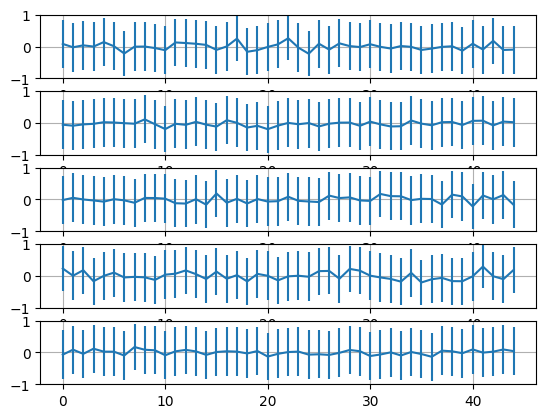

In [30]:
# verify chaos
[fig, subfig_s] = plt.subplots(int(connectivity_n),1)
for connectivity_idx in range(connectivity_n):
  subfig_s[connectivity_idx].errorbar(jnp.arange(initial_condition_n_free), 
                                      jnp.mean(traj_s_free[0][connectivity_idx,0,0,0], axis = (-2, -1)),
                                      yerr=jnp.var(traj_s_free[0][connectivity_idx,0,0,0], axis = (-2, -1)))
  subfig_s[connectivity_idx].set_ylim(-1,1)
  subfig_s[connectivity_idx].grid()

means and pcs and stats

In [18]:
unit_interval_len = 60
unit_interval_n = (interval_len - waiting_len) // unit_interval_len
short_interval_len_s = jnp.asarray([1,2,5,10])#jnp.asarray([1,2,3,4,5,6,10,12,15,20,30,60])
short_interval_n_s = unit_interval_n // short_interval_len_s
short_interval_len_n = short_interval_len_s.shape[0]

In [21]:
# reshape for Ts
condition_n_s_free_reshaped = tuple(condition_n_s_free)
condition_n_s_reshaped = tuple(condition_n_s)

traj_s_free_reshaped = jnp.swapaxes(traj_s_free[0].reshape(condition_n_s_free_reshaped 
                                                                          + (part_n, unit_interval_n, unit_interval_len)), -2, -3)
traj_s_reshaped = jnp.swapaxes(traj_s[0].reshape(condition_n_s_reshaped
                                                                + (part_n, unit_interval_n, unit_interval_len)), -2, -3)

In [22]:
# basic stats
mean_s_free = mean_s_fct(traj_s_free_reshaped)
mean_s = mean_s_fct(traj_s_reshaped)
cov_s_free = cov_s_fct(traj_s_free_reshaped, mean_s_free)
cov_s = cov_s_fct(traj_s_reshaped, mean_s)

In [23]:
# eigenvalue stats
tr_s_free = np.zeros((short_interval_len_n, )+condition_n_s_free_reshaped)
tr_s = np.zeros((short_interval_len_n, )+condition_n_s_reshaped)
pr_s_free = np.zeros((short_interval_len_n, )+condition_n_s_free_reshaped)
pr_s = np.zeros((short_interval_len_n, )+condition_n_s_reshaped)

for short_interval_len_idx in range(short_interval_len_n):
  short_interval_len = short_interval_len_s[short_interval_len_idx]
  short_interval_n = short_interval_n_s[short_interval_len_idx]
  cov_s_longer_free = jnp.mean(cov_s_free.reshape(condition_n_s_free_reshaped 
                                                  + (short_interval_n, short_interval_len, part_n, part_n)),
                               axis = -3)
  cov_s_longer = jnp.mean(cov_s.reshape(condition_n_s_reshaped 
                                        + (short_interval_n, short_interval_len, part_n, part_n)),
                               axis = -3)
  pc_var_s_free = es_s_fct(cov_s_longer_free)[0]
  pc_var_s = es_s_fct(cov_s_longer)[0]
  tr_s_free[short_interval_len_idx] = jnp.mean(size_s_fct(pc_var_s_free), axis = -1)
  tr_s[short_interval_len_idx] = jnp.mean(size_s_fct(pc_var_s), axis = -1)
  pr_s_free[short_interval_len_idx] = jnp.mean(dim_r_s_fct(pc_var_s_free), axis = -1)
  pr_s[short_interval_len_idx] = jnp.mean(dim_r_s_fct(pc_var_s), axis = -1)

np.savez_compressed(subdirectory + "trs_prs.npz", tr_s_free, tr_s, pr_s_free, pr_s)

In [24]:
# load ea stats
[tr_s_free_foo, tr_s_foo, pr_s_free_foo, pr_s_foo] = load_as_list(subdirectory + "trs_prs.npz")

[[0.2]
 [0.4]
 [0.8]]


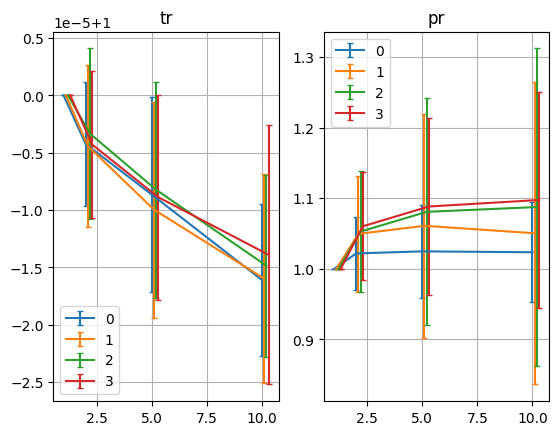

In [32]:
tr_stat_s_free = [jnp.mean(tr_s_free/tr_s_free[0:1], axis = (1,3,4,5)),
                 jnp.std(tr_s_free/tr_s_free[0:1], axis = (1,3,4,5))]
tr_stat_s = [jnp.mean(tr_s/tr_s[0:1], axis = (1,3,4,5)),
            jnp.std(tr_s/tr_s[0:1], axis = (1,3,4,5))]
tr_stat_s_all = [jnp.concatenate([tr_stat_s_free[idx], tr_stat_s[idx]], axis = -1) for idx in range(2)]

pr_stat_s_free = [jnp.mean(pr_s_free/pr_s_free[0:1], axis = (1,3,4,5)),
                 jnp.std(pr_s_free/pr_s_free[0:1], axis = (1,3,4,5))]
pr_stat_s = [jnp.mean(pr_s/pr_s[0:1], axis = (1,3,4,5)),
            jnp.std(pr_s/pr_s[0:1], axis = (1,3,4,5))]
pr_stat_s_all = [jnp.concatenate([pr_stat_s_free[idx], pr_stat_s[idx]], axis = -1) for idx in range(2)]

[fig, subfig_s] = plt.subplots(1, 2)
subfig_s[0].title.set_text("tr")
subfig_s[1].title.set_text("pr")
for wave_idx in range(wave_n+1):
  subfig_s[0].errorbar(short_interval_len_s+wave_idx/10,tr_stat_s_all[0][:,wave_idx],yerr = tr_stat_s_all[1][:,wave_idx],
                      capsize=2, label=str(wave_idx))
  subfig_s[1].errorbar(short_interval_len_s+wave_idx/10,pr_stat_s_all[0][:,wave_idx],yerr = pr_stat_s_all[1][:,wave_idx],
                      capsize=2, label=str(wave_idx))
subfig_s[0].legend()
subfig_s[1].legend()
subfig_s[0].grid()
subfig_s[1].grid()
print(amp_s)